# Main testing

In [26]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *

## Environment initialization

In [27]:
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel", "colors"))
state = env.reset()

In [28]:
game_map = state['chars'].copy()
game_gui = state['pixel']

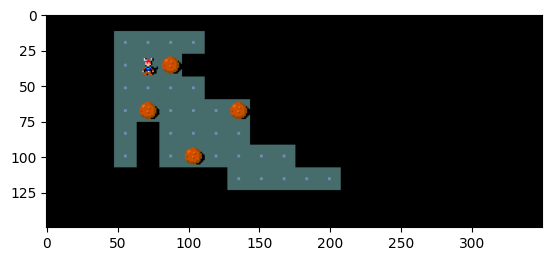

In [29]:
plt.imshow(game_gui[100:250, 400:750]) #Immagine ristretta con range [y][x]

In [30]:
find_river(env, game_map, state['colors'])
env.render()


                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                            ..................}                                 
                            .<`...............}                                 
                            ..@..........`                                      
                            .`...`   .........}                                 
                           